In [1]:
%matplotlib inline


# Averaging multiple FITS file Images and producing a Spectroscopic Graph


This notebook will open all the FITS file in a single folder and averages it. It will also produce a graph of intensity vs pixel number

This example uses `astropy.utils.data` to download the file, `astropy.io.fits` to open
the file, and `matplotlib.pyplot` to display the image.

-------------------

*By: Emir Muhammad and Edward Penny*

*License: BSD*

-------------------





Set up matplotlib, numpy, astropy and os modules


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit


### Importing all the necessary strings for importing the data
The code below works for only Emir and Edward on their own machines, as this is where they have placed their data. If you wish to run this correctly on your machine, please copy the required code below and do the necessary changes

In [3]:
name_of_owner = 'Edward'

if name_of_owner == 'Emir':
    Xenonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Xenon Data/' 
    Kryptonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Krypton Data/' 
    Argonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Argon Data/'
    Neonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Neon Data/'
    Heliumlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Helium 500/'
    Cadmiumlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Cadmium Calibration Data/'
    LampNeonlocation = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Neon discharge lamp data/'

    heliumtext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/helium.txt'
    neontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/neon.txt'
    argontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/fakeargon.txt' #YO THIS THING IS FAKE ARGON
    kryptontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/krypton.txt'
    xenontext = '/Users/emirmuhammad/Desktop/Ed-Em-Y2Spec/Atomic Data/xenon.txt'
    
    print('You are a bold one.')
elif name_of_owner == 'Edward': 
    Xenonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Xenon data/'  
    Kryptonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Krypton data/'  
    Argonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Argon Data/'
    Neonlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Neon Data/'
    Heliumlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Helium Data/'
    Cadmiumlocation = '/Users/Edward/Documents/year 2/lab project/Ed-Em-Y2Spec/Cadmium Calibration Data/'

    heliumtext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/helium.txt'
    neontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/neon.txt'
    argontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/argon.txt'
    kryptontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/krypton.txt'
    xenontext = '/Users/Edward/Documents/year 2/lab project/Atomic Data/xenon.txt'
    
    print('This code is too important for me to allow you to jeopardize it')

else:
    print('please add in the correct name, else the entire code will not run.')
    print(0/0)

This code is too important for me to allow you to jeopardize it


# Defining the required functions for plotting and analyzing the spectrum

In [4]:
def mean_data(location):
    '''Requires the location as a folder for where all the data is kept, and all the data should be a fit file.
    Returns a 2d array, of the average values from all files'''
    tracks = []
    for i in os.listdir(location):
        if i.endswith(".fit"):
            filename =location + '/' + str(i)
            image_file = get_pkg_data_filename(filename)
            image_data = fits.getdata(image_file, ext=0) #uses astropy module to convert the fit file into an array
            tracks.append(image_data)
    mean = np.mean(tracks, axis = 0)
    return mean

In [5]:
def plot_datapx(data, a=240, b=360):
    '''plots the data, intensity vs pixel as well as the image itself'''
    data = data
    snipmean = data[a:b]   #snipmean isolates a rectangular section of the image
    numberofx = snipmean.shape[1]
    x = np.linspace(1, numberofx, numberofx)
    y = np.mean(snipmean, axis = 0)
    plt.title('Plot of superMean Intensity Vs Pixel Number') #you should change this with the title
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Intensity(arbitrary units)')
    plt.plot(x, y)
    plt.show()
    plt.figure()
    plt.imshow(data, cmap='gray')
    plt.colorbar()

In [6]:
def plot_datawv(data, a=240, b=360, MINspacebetweenpeaks = 10, PROMCUTOFF = 250, Element = None):
    '''plots data, intensity vs wavelength. Wavelength calibration was done in labs'''
    data = data
    snipmean = data[a:b]      #snipmean isolates a rectangular section of the image
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10) #wavelength calibration
    B = 2.736*10**(-7)  #wavelength calibration
    x = A*xt + B        #wavelength calibration
    y = np.mean(snipmean, axis = 0)
    if Element == None:  #title plotting
        plt.title(f'Plot of Mean Intensity Vs Wavelength')
    else:
        plt.title(f'Plot of Mean Intensity Vs Wavelength {Element}')
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Intensity(arbitrary units)')
    
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's
    proms[proms == PROMCUTOFF] = 1 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    for n in np.nditer(keypeaks):
        plt.axvline(x= A*n+ B,linestyle=':', color = 'r', label='f0')
    plt.plot(x, y)
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]
    plt.show()
    return None

In [7]:
def peaks_datawv(data, a=210, b=410, MINspacebetweenpeaks = 10, PROMCUTOFF = 250):
    '''returns a dictionary of distinct peaks in a specified range'''
    data = data
    snipmean = data[a:b]
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10) #calibration from pixels to wavelengths
    B = 2.736*10**(-7)
    x = A*xt + B
    y = np.mean(snipmean, axis = 0)
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]
    return Peaksdict

In [8]:
def extrainfo(data, a=240, b=360, MINspacebetweenpeaks = 10, PROMCUTOFF = 250):
    ''' returns a list of arrays containing (wavelength, width, intensity) of each peak'''
    data = data
    snipmean = data[a:b]
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10)
    B = 2.736*10**(-7)
    x = A*xt + B
    y = np.mean(snipmean, axis = 0)
    peaks,_ = find_peaks(y, distance = MINspacebetweenpeaks)
    proms = peak_prominences(y, peaks)[0]
    proms[proms < PROMCUTOFF] = 0 # making an array of 1's and 0's 
    promsford = list(proms)
    L0 = promsford.count(0)
    DC = 0
    while DC<L0:
        DC +=1
        promsford.remove(0) # finding prominences for the dictionary
    proms[proms > PROMCUTOFF] = 1 # making an array of 1's and 0's 
    keypeaks = proms*peaks # setting all peaks with low prominences to 0
    Lkeypeaks = list(keypeaks) # have to make it into a list to use count and remove
    L1= Lkeypeaks.count(0) # finding the number of 0's for the loop
    RC= 0 
    while RC<L1:
        RC +=1
        Lkeypeaks.remove(0) # remove only removes the first 0 so have to loop it through
    keypeaks = np.array(Lkeypeaks) # convert back to an array for the graphing
    Wavelengthsford= A*keypeaks + B
    Wavelengthsford = list(Wavelengthsford) #getting wavelengths of peaks for the dictionary
    Peaksdict = {}
    for i in range(len(promsford)): #assembling the peak dictionary
        Peaksdict[Wavelengthsford[i]] = promsford[i]

        
    '''finding rel intensities'''
    keypeaks =keypeaks.astype(int)
    peaksy = []
    for n in keypeaks:
        peaksy.append(y[n])
    TT=np.max(peaksy)
    relint=(peaksy) #replace 1 with 1000/TT
    Relintdict = {}
    for i in range(len(peaksy)):
        Relintdict[Wavelengthsford[i]] = relint[i]
    widths = peak_widths(y, keypeaks)
    Wavelengthsford=np.array(Wavelengthsford)
    widths=widths[0]
    GD=[]
    for a,b,c in zip(Wavelengthsford,relint,widths):
        temp=(a, c*A, b)
        GD.append(temp)
    return(GD)

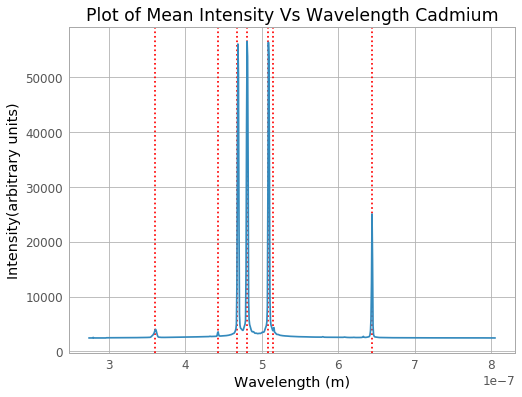

In [9]:
plot_datawv(mean_data(Cadmiumlocation), Element = 'Cadmium')

# Importing the dictionaries from the text files

In [10]:
def importdict(textlocation):
    f=open(textlocation,"r")
    lines=f.readlines()
    result=[]
    results2 = []
    for x in lines:
        result.append(x.split(' ')[0])
        results2.append(x.split(' ')[-1])
    f.close()
    a = [float(i) for i in results2]
    #in this bit put the code to ma
    temp = {}
    results = [float(i)*10**(-10) for i in result]
    for i in range(len(result)): #assembling the peak dictionary
        temp[results[i]] = a[i]
    return temp

Heliumdict = importdict(heliumtext)
Neondict = importdict(neontext)
Argondict = importdict(argontext)
Kryptondict = importdict(kryptontext)
Xenondict = importdict(xenontext)

print(Heliumdict)

{3.9647300000000003e-07: 20.0, 4.00927e-07: 1.0, 4.02619e-07: 50.0, 4.02636e-07: 5.0, 4.1208199999999997e-07: 12.0, 4.12099e-07: 2.0, 4.1437600000000003e-07: 3.0, 4.3879300000000006e-07: 10.0, 4.43755e-07: 3.0, 4.47148e-07: 200.0, 4.4716800000000005e-07: 25.0, 4.6854e-07: 6.0, 4.6857e-07: 30.0, 4.71315e-07: 30.0, 4.7133800000000003e-07: 4.0, 4.92193e-07: 20.0, 5.015680000000001e-07: 100.0, 5.04774e-07: 10.0, 5.411520000000001e-07: 5.0, 5.87562e-07: 500.0, 5.87597e-07: 100.0, 6.5601e-07: 8.0, 6.67815e-07: 100.0, 6.86748e-07: 3.0, 7.06519e-07: 200.0, 7.06571e-07: 30.0}


In [11]:
'''Master Dictionary'''
True_element_rel_in_d = {'He': Heliumdict, 'Ne' : Neondict, 'Ar' : Argondict, 'Kr':  Kryptondict, 'Xe' : Xenondict}

'''datad is the dictionary of element and wavelengths'''
datad= {}
for keys in True_element_rel_in_d.keys():
    datad.update({f'{keys}': list(True_element_rel_in_d.get(f'{keys}').keys())})

## Wavelength matching function

In [12]:
def matchelements(location): 
    testunknown= peaks_datawv(mean_data(location))
    unknown = list(testunknown.keys())
    founddict = {}
    for element in datad.keys():
        thelist = []
        for x in unknown:
            for y in datad.get(element):
                if abs(x - y) < 2*6.640*10**(-10):  #GET RID OF THE TIMES 2 MULTIPLE
                    thelist.append(round(y, 11))
        founddict.update({f'{element}' : thelist})
    return founddict

In [13]:
print(matchelements(Xenonlocation))
print('')
print(matchelements(Kryptonlocation))
print('')
print(matchelements(Argonlocation))
print('')
print(matchelements(Neonlocation))
print('')
print(matchelements(Heliumlocation))

{'He': [4.7131e-07, 4.7134e-07], 'Ne': [4.5377e-07, 4.5404e-07, 4.7044e-07, 4.7089e-07, 4.7101e-07, 4.7121e-07, 4.7154e-07, 5.4006e-07], 'Ar': [4.5306e-07, 4.5451e-07, 4.7023e-07, 4.7649e-07, 4.8478e-07, 4.9651e-07], 'Kr': [4.7624e-07, 4.7657e-07, 4.8321e-07, 4.8466e-07, 4.9456e-07], 'Xe': [4.8297e-07, 4.8433e-07, 5.3928e-07]}

{'He': [4.1438e-07, 4.7131e-07, 4.7134e-07, 4.9219e-07], 'Ne': [4.4093e-07, 4.4132e-07, 4.4214e-07, 4.4285e-07, 4.4286e-07, 4.4309e-07, 4.4309e-07, 4.5377e-07, 4.5404e-07, 4.7089e-07, 4.7101e-07, 4.7121e-07, 4.7154e-07, 5.8819e-07, 5.9025e-07, 6.0743e-07], 'Ar': [4.1561e-07, 4.1586e-07, 4.3092e-07, 4.426e-07, 4.4302e-07, 4.431e-07, 4.4338e-07, 4.5451e-07, 4.6372e-07, 4.6579e-07, 4.7216e-07, 4.7269e-07, 4.7321e-07, 4.9332e-07, 5.0905e-07, 5.1623e-07, 5.1658e-07, 5.8826e-07, 5.8886e-07, 6.0594e-07], 'Kr': [4.1451e-07, 4.3178e-07, 4.3186e-07, 4.3196e-07, 4.323e-07, 4.4252e-07, 4.4317e-07, 4.5566e-07, 4.6589e-07, 5.0865e-07, 5.5804e-07, 6.0561e-07], 'Xe': [4.158e-07

# Gaussian Conversion

In [14]:
def gaussian(x, mu, sig, a, fudge = 0):
    return a*np.exp(-np.power(x - mu - fudge, 2.) / (2 * np.power(sig, 2.)))

def fullgaussian(x, y, fudge = 0):
    b = 0
    for mu, sig, a in y:
        b += gaussian(x, mu, sig, a, fudge)
    return b
    
def plotgaussiandict(useddict, Element = None):
    emptylist = []
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    useddict = useddict
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*100)
        emptylist.append(temp)
    plt.plot(x_values, fullgaussian(x_values, emptylist))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    if Element == None:
        plt.title(f'Gaussian-Converted Plot of Dictionary')
    else:
        plt.title(f'Gaussian-Converted Plot of Dictionary {Element}')
    plt.show()
    
def plotgaussianspectrum(location, Element = None):
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    plt.plot(x_values-1, fullgaussian(x_values, y))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    if Element == None:
        plt.title(f'Gaussian-Converted Plot of Captured Spectrum')
    else:
        plt.title(f'Gaussian-Converted Plot of Captured {Element} Spectrum')
    plt.show()

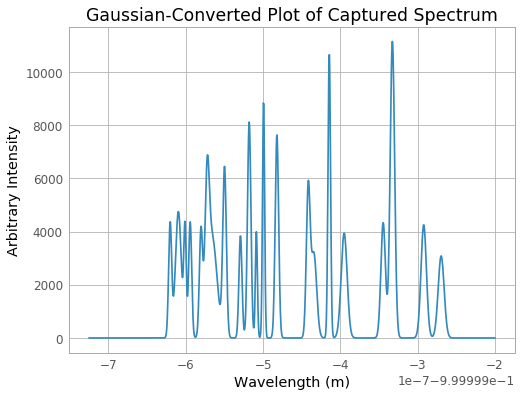

In [15]:
plotgaussianspectrum(Heliumlocation)

In [16]:
def plotgaussianmatchedspect(location, Element = None):
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    plt.plot(x_values, fullgaussian(x_values, y))
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    testloc = matchelements(location)
    for a in testloc.keys():
        if a == 'He':
            color = 'b'
        elif a == 'Ne':
            color = 'g'
        elif a == 'Ar':
            color = 'r'
        elif a == 'Kr':
            color = 'c'
        elif a == 'Xe':
            color = 'm'
        plt.axvline(testloc[a][0], linestyle=':', color = color, label = a) #duplicate line for labeling purposes
        for x in testloc[a]:
            plt.axvline(x,linestyle=':', color = color)            
    if Element == None:
        plt.title(f'Plot of Matched Gaussian Lines')
    else:
        plt.title(f'Plot of Matched Gaussian Lines {Element}')
    plt.legend()
    plt.show()

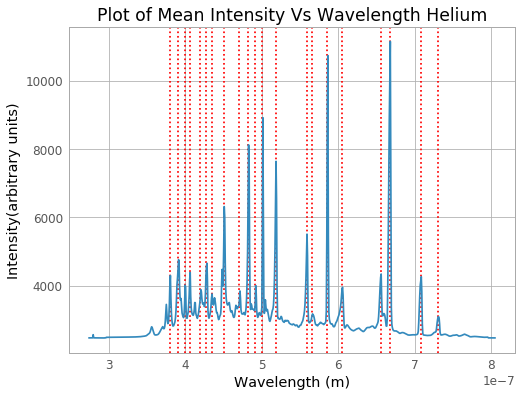

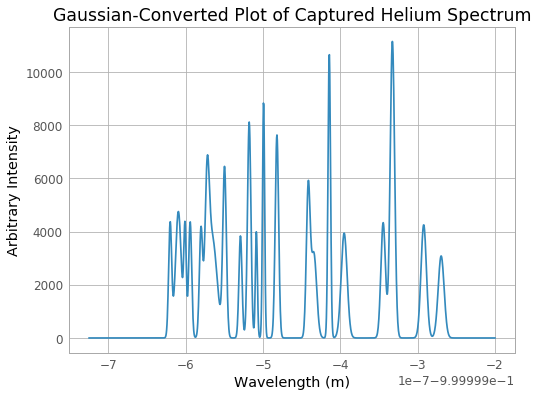

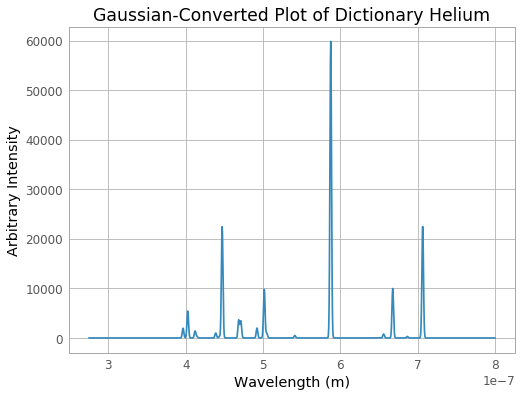

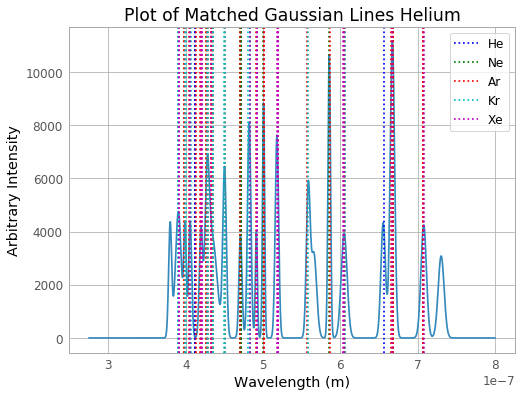

In [17]:
plot_datawv(mean_data(Heliumlocation), Element = 'Helium')
plotgaussianspectrum(Heliumlocation, Element = 'Helium')
plotgaussiandict(Heliumdict, Element = 'Helium')
plotgaussianmatchedspect(Heliumlocation, Element = 'Helium')

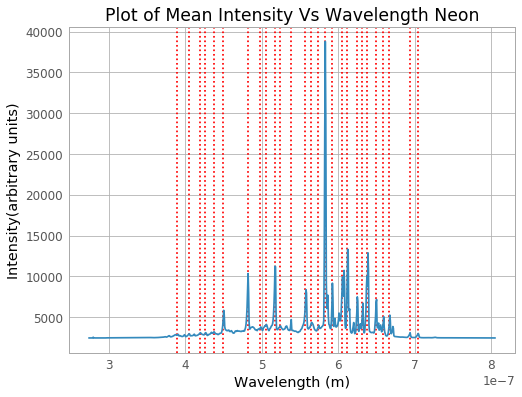

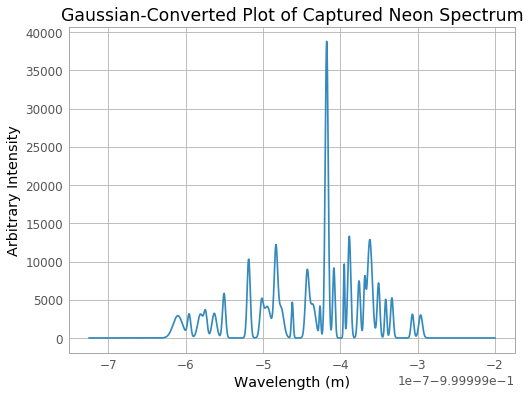

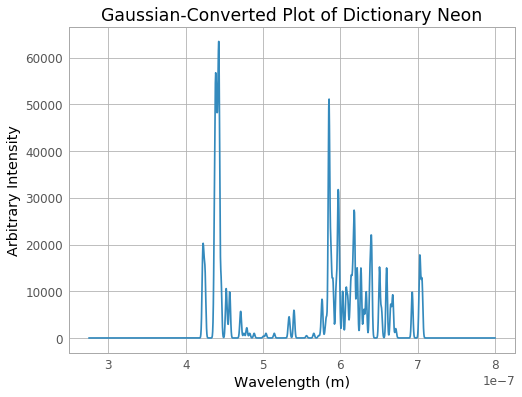

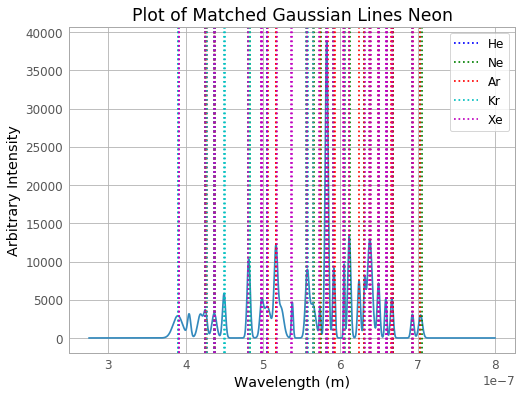

In [18]:
plot_datawv(mean_data(Neonlocation), Element = 'Neon')
plotgaussianspectrum(Neonlocation, Element = 'Neon')
plotgaussiandict(Neondict, Element = 'Neon')
plotgaussianmatchedspect(Neonlocation, Element = 'Neon')

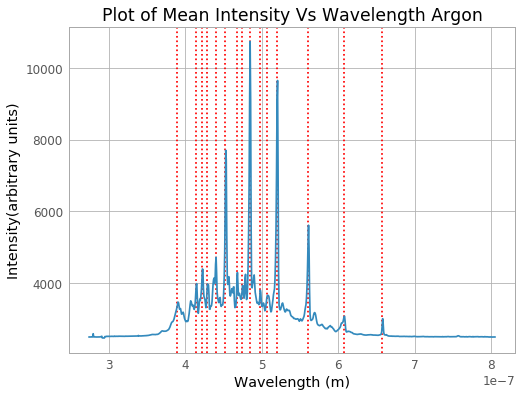

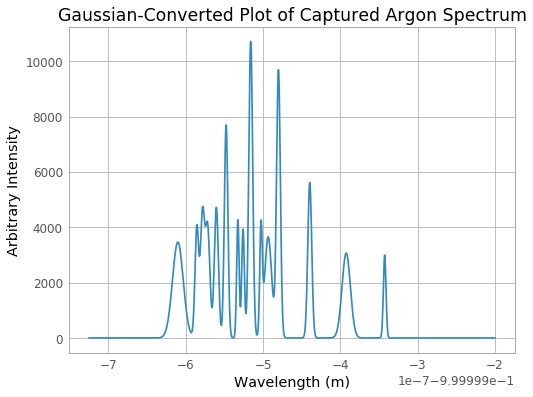

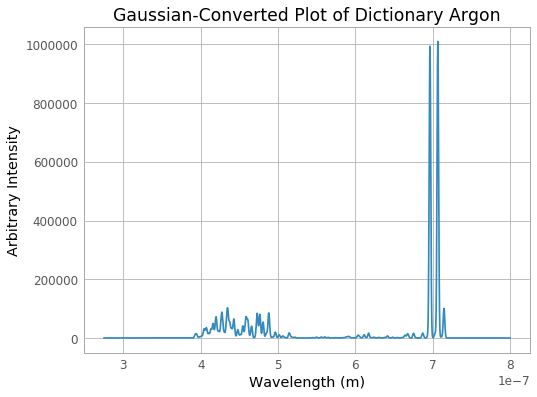

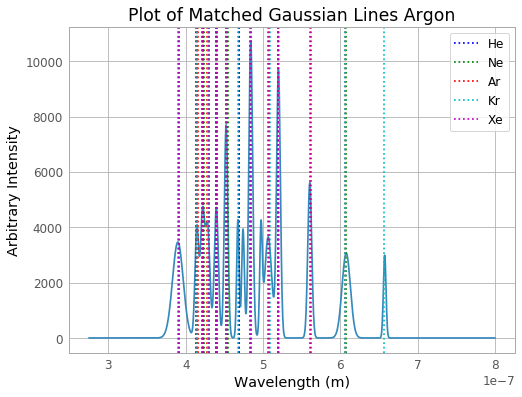

In [19]:
plot_datawv(mean_data(Argonlocation), Element = 'Argon')
plotgaussianspectrum(Argonlocation, Element = 'Argon')
plotgaussiandict(Argondict, Element = 'Argon')
plotgaussianmatchedspect(Argonlocation, Element = 'Argon')

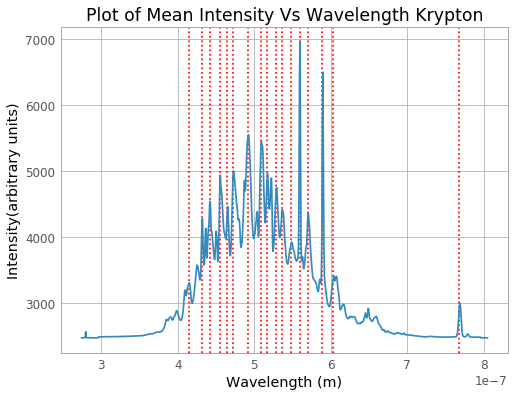

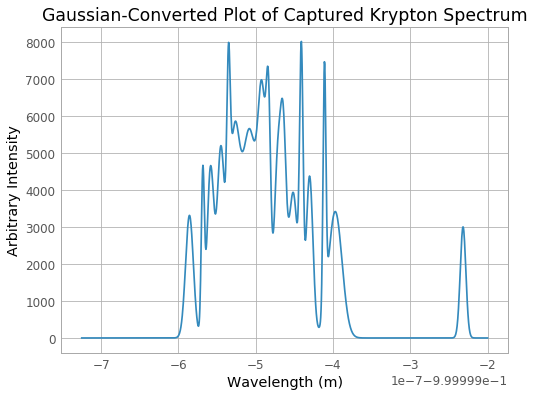

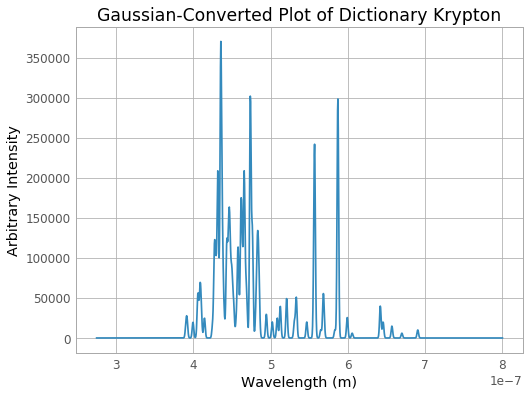

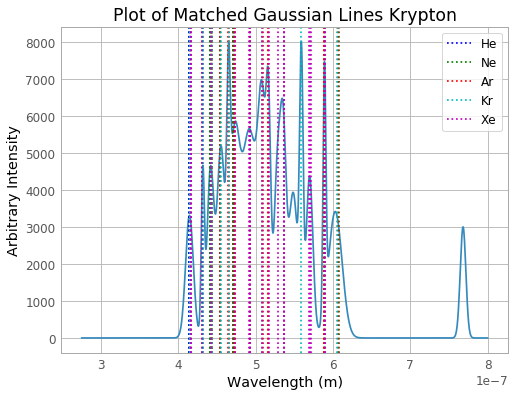

In [20]:
plot_datawv(mean_data(Kryptonlocation), Element = 'Krypton')
plotgaussianspectrum(Kryptonlocation, Element = 'Krypton')
plotgaussiandict(Kryptondict, Element = 'Krypton')
plotgaussianmatchedspect(Kryptonlocation, Element = 'Krypton')

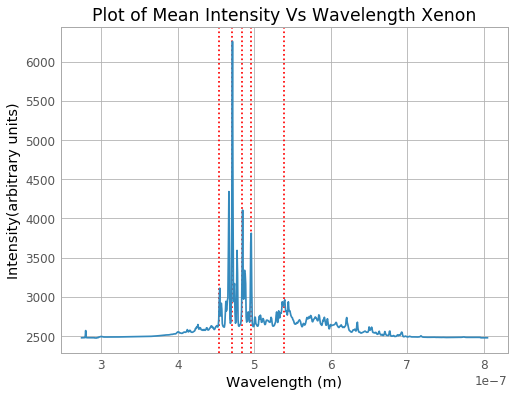

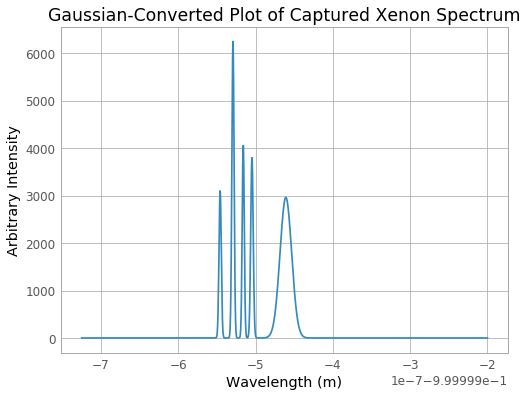

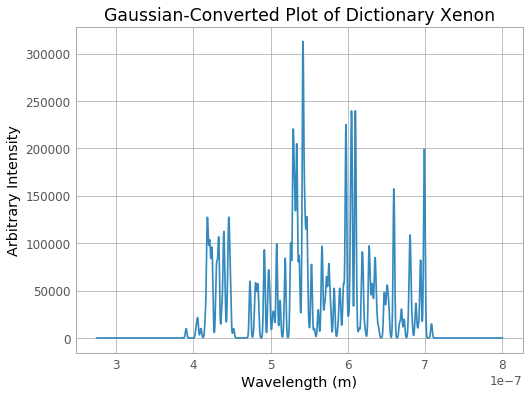

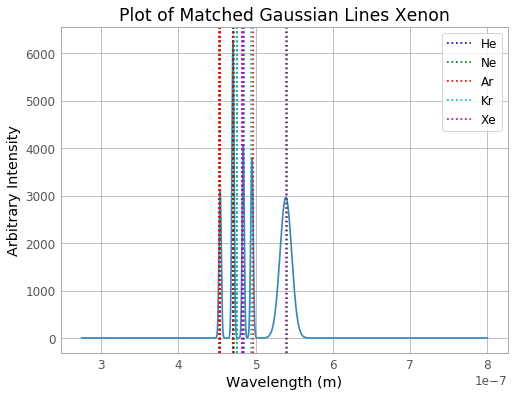

In [21]:
plot_datawv(mean_data(Xenonlocation), Element = 'Xenon')
plotgaussianspectrum(Xenonlocation, Element = 'Xenon')
plotgaussiandict(Xenondict, Element = 'Xenon')
plotgaussianmatchedspect(Xenonlocation, Element = 'Xenon')

In [22]:
plot_datawv(mean_data(LampNeonlocation), Element = 'Neon Lamp')
plotgaussianspectrum(LampNeonlocation, Element = 'Neon Lamp')
plotgaussiandict(Neondict, Element = 'Neon Lamp')
plotgaussianmatchedspect(LampNeonlocation, Element = 'Neon Lamp')

NameError: name 'LampNeonlocation' is not defined

### An attempt at actually seeing which bits are matched up 

In [ ]:
def plotgaussiandicttemp(useddict, x_values, multiple):
    emptylist = []
    useddict = useddict
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*multiple)
        emptylist.append(temp)
    plt.plot(x_values, fullgaussian(x_values, emptylist), label = 'database', alpha = 0.5, marker = ',')


def tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 50):
    #testloc = matchelements(location)
    plt.axvline(testloc[a][0], linestyle=':', color = color, label = a)
    for x in testloc[a]:
        plt.axvline(x,linestyle=':', color = color)
    if Element == None:
        plt.title(f'Plot of Matched Gaussian Lines')
    else:
        plt.title(f'Plot of Matched Gaussian Lines {Element}')
    plt.plot(x_values, fullgaussian(x_values, y))
    plotgaussiandicttemp(True_element_rel_in_d[a], x_values, multiple)    
    plt.xlabel(r'Wavelength (m)')
    plt.ylabel(r'Arbitrary Intensity')
    plt.legend()
    plt.show()

def plotgaussiananalysis(location, Element = None):
    location = location
    testloc = matchelements(location)
    x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
    y = extrainfo(mean_data(location))
    for a in testloc.keys():
        if a == 'He':
            color = 'b'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 15)
        elif a == 'Ne':
            color = 'g'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 50)
        elif a == 'Ar':
            color = 'r'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 7.5)
        elif a == 'Kr':
            color = 'c'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 5)
        elif a == 'Xe':
            color = 'm'
            tempanalysis(a, location, testloc, color, Element, x_values, y, multiple = 10)

In [ ]:
plotgaussiananalysis(Heliumlocation, Element = 'Helium')

In [ ]:
plotgaussiananalysis(Neonlocation, Element = 'Neon')

In [ ]:
plotgaussiananalysis(Argonlocation, Element = 'Argon')

In [ ]:
plotgaussiananalysis(Kryptonlocation, Element = 'Krypton')

In [ ]:
plotgaussiananalysis(Xenonlocation, Element = 'Xenon')

In [ ]:
plotgaussiananalysis(LampNeonlocation, Element = 'Neon Lamp')

# Scaling Dictionaries

In [ ]:
#Scaling Factor Calculation
#Database is wavelength = this and intensity = this
#I = AE
I = 5.7234*10**(-12)
scale = I/50

In [ ]:
#Creating a new dictionary
#HeliumRelativelyTrueDict = {}
'''
for wavelength in Heliumdict:
    HeliumRelativelyTrueDict.update({wavelength : Heliumdict[wavelength]*scale})
    
    '''

In [ ]:
def scaleme(dictionary,I, wvint):
    temp = {}
    scale = I/wvint #inputscaleing here
    for wavelength in dictionary:
        temp.update({wavelength : dictionary[wavelength]*scale})
    return temp
HeRelativelyTrueDict = scaleme(Heliumdict, 5.7234*10**(-12), 50)
NeRelativelyTrueDict = scaleme(Neondict, 2.278*10**(-11), 500 )
ArRelativelyTrueDict = scaleme(Argondict, 1.856*10**(-12), 200)
KrRelativelyTrueDict = scaleme(Kryptondict, 7.49*10**(-13), 2000)
XeRelativelyTrueDict = scaleme(Xenondict, 1.773*10**(-12), 500)

# Curve Fitting

In [ ]:
def _generalizedgaussian(useddict):
    useddict = useddict
    emptylist = []
    for x in useddict:
        temp = (x, 1e-09, useddict[x]*10**(10))
        emptylist.append(temp)
    return emptylist
def generalizedgaussian(x, a, b, c, d, e, fudge):
    HeList = _generalizedgaussian(HeRelativelyTrueDict)
    NeList = _generalizedgaussian(NeRelativelyTrueDict)
    ArList = _generalizedgaussian(ArRelativelyTrueDict)
    KrList = _generalizedgaussian(KrRelativelyTrueDict)
    XeList = _generalizedgaussian(XeRelativelyTrueDict)
    
    function = 0 
    function += a*fullgaussian(x, HeList, fudge)
    function += b*fullgaussian(x, NeList, fudge)
    function += c*fullgaussian(x, ArList, fudge)
    function += d*fullgaussian(x, KrList, fudge)
    function += e*fullgaussian(x, XeList, fudge)
    return function

In [ ]:
x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
xdata = x_values
ydata = generalizedgaussian(xdata, 1, 0, 0, 0, 0, 1*10**(-7))
plt.plot(xdata, ydata, label = 'captured', alpha = 1)
plt.legend()
plt.show()

In [ ]:
location= Heliumlocation

x_values = np.linspace(2.75*10**(-7), 8*10**(-7), 1200)
xdata = x_values


variable = 1
if variable == 1:
    y = extrainfo(mean_data(location))
    ydata = fullgaussian(x_values, y)
else:
    data = mean_data(Heliumlocation)
    snipmean = data[240:360]      
    numberofx = snipmean.shape[1]
    xt = np.linspace(1, numberofx, numberofx)
    A = 6.640*10**(-10)
    B = 2.736*10**(-7)
    xdata = A*(xt) + B
    ydata = np.mean(snipmean - 2480, axis = 0)

func = generalizedgaussian
p0 = (1000, 0, 0, 0, 0, 0)
popt, pcov = curve_fit(func, xdata, ydata, p0 = p0, bounds = (0, np.inf))
print(popt)


In [ ]:
plt.plot(x_values, generalizedgaussian(x_values, a=popt[0], b=popt[1], c=popt[2], d=popt[3], e=popt[4], fudge=popt[5]), label = 'fit')
#plt.plot(x_values, generalizedgaussian(x_values, a=60000, b=80000, c=0, d=0, e=80000), label = 'fit')
plt.plot(xdata, ydata, label = 'captured', alpha = 0.5)
plt.legend()
plt.show()

# Anything below this is scrap

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import numpy as np


star = mpath.Path.unit_regular_star(4)
circle = mpath.Path.unit_circle()
# concatenate the circle with an internal cutout of the star
verts = np.concatenate([circle.vertices, star.vertices[::-1, ...]])
codes = np.concatenate([circle.codes, star.codes])
cut_star = mpath.Path(verts, codes)


plt.plot(np.arange(10)**2, '--r', marker=cut_star, markersize=15)

plt.show()

In [ ]:
print(peaks_datawv(mean_data(Heliumlocation)))